# Splitting Dataset

Based on my exploration on the time series aspect of the dataset, there's some problem that need to be handled:
- There are some duplicated data (some row have same datetime)
- Number of record each day is different (some have complete 24 hours, some only have part of it)
- There are some missing days (some days doesn't even have a record)
- There is a big gap in the middle of the dataset

To be concluded, the dataset has irregular timesteps. This is not a good thing. To make a good NN model, we need to handle it. How?
- Aggregation
- split dataset into two
- fill remain null records

**input:**
- dataset/Train.csv -> The main dataset from kaggle

**output:**
- dataset/firsthalf_v3.csv -> timeseries problem handled, firsthalf of the main data
- dataset/secondhalf_v3.csv -> timeseries problem handled, second of the main data

# Import Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Datasets

In [50]:
df = pd.read_csv('dataset/Train.csv')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            33750 non-null  object 
 1   is_holiday           43 non-null     object 
 2   air_pollution_index  33750 non-null  int64  
 3   humidity             33750 non-null  int64  
 4   wind_speed           33750 non-null  int64  
 5   wind_direction       33750 non-null  int64  
 6   visibility_in_miles  33750 non-null  int64  
 7   dew_point            33750 non-null  int64  
 8   temperature          33750 non-null  float64
 9   rain_p_h             33750 non-null  float64
 10  snow_p_h             33750 non-null  float64
 11  clouds_all           33750 non-null  int64  
 12  weather_type         33750 non-null  object 
 13  weather_description  33750 non-null  object 
 14  traffic_volume       33750 non-null  int64  
dtypes: float64(3), int64(8), object(4)
m

In [52]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [53]:
cat_columns = ['is_holiday', 'weather_type', 'weather_description']

df[cat_columns] = df[cat_columns].apply(lambda x: x.str.lower())

In [54]:
df['is_holiday'].value_counts()

is_holiday
thanksgiving day             5
christmas day                5
new years day                5
columbus day                 4
veterans day                 4
washingtons birthday         4
labor day                    4
memorial day                 3
independence day             3
state fair                   3
martin luther king jr day    3
Name: count, dtype: int64

# Aggregate using groupby()

In [55]:
agg_funcs = {
    'is_holiday': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'air_pollution_index': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'wind_direction': 'mean',
    'visibility_in_miles': 'mean',
    'dew_point': 'mean',
    'temperature': 'mean',
    'rain_p_h': 'mean',
    'snow_p_h': 'mean',
    'clouds_all': 'mean',
    'weather_type': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'weather_description': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'traffic_volume': 'mean'
}

# Perform groupby and aggregation
df_grouped = df.groupby('date_time').agg(agg_funcs).reset_index()

In [56]:
df_grouped.info()
df_grouped.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28589 entries, 0 to 28588
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            28589 non-null  datetime64[ns]
 1   is_holiday           38 non-null     object        
 2   air_pollution_index  28589 non-null  float64       
 3   humidity             28589 non-null  float64       
 4   wind_speed           28589 non-null  float64       
 5   wind_direction       28589 non-null  float64       
 6   visibility_in_miles  28589 non-null  float64       
 7   dew_point            28589 non-null  float64       
 8   temperature          28589 non-null  float64       
 9   rain_p_h             28589 non-null  float64       
 10  snow_p_h             28589 non-null  float64       
 11  clouds_all           28589 non-null  float64       
 12  weather_type         28589 non-null  object        
 13  weather_description  28589 non-

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,None,121.0,89.0,2.0,329.0,1.0,1.0,288.28,0.0,0.0,40.0,clouds,scattered clouds,5545.0
1,2012-10-02 10:00:00,None,178.0,67.0,3.0,330.0,1.0,1.0,289.36,0.0,0.0,75.0,clouds,broken clouds,4516.0
2,2012-10-02 11:00:00,None,113.0,66.0,3.0,329.0,2.0,2.0,289.58,0.0,0.0,90.0,clouds,overcast clouds,4767.0
3,2012-10-02 12:00:00,None,20.0,66.0,3.0,329.0,5.0,5.0,290.13,0.0,0.0,90.0,clouds,overcast clouds,5026.0
4,2012-10-02 13:00:00,None,281.0,65.0,3.0,329.0,7.0,7.0,291.14,0.0,0.0,75.0,clouds,broken clouds,4918.0


# Split to 2 datasets

In [57]:
df_grouped = df_grouped.set_index('date_time')

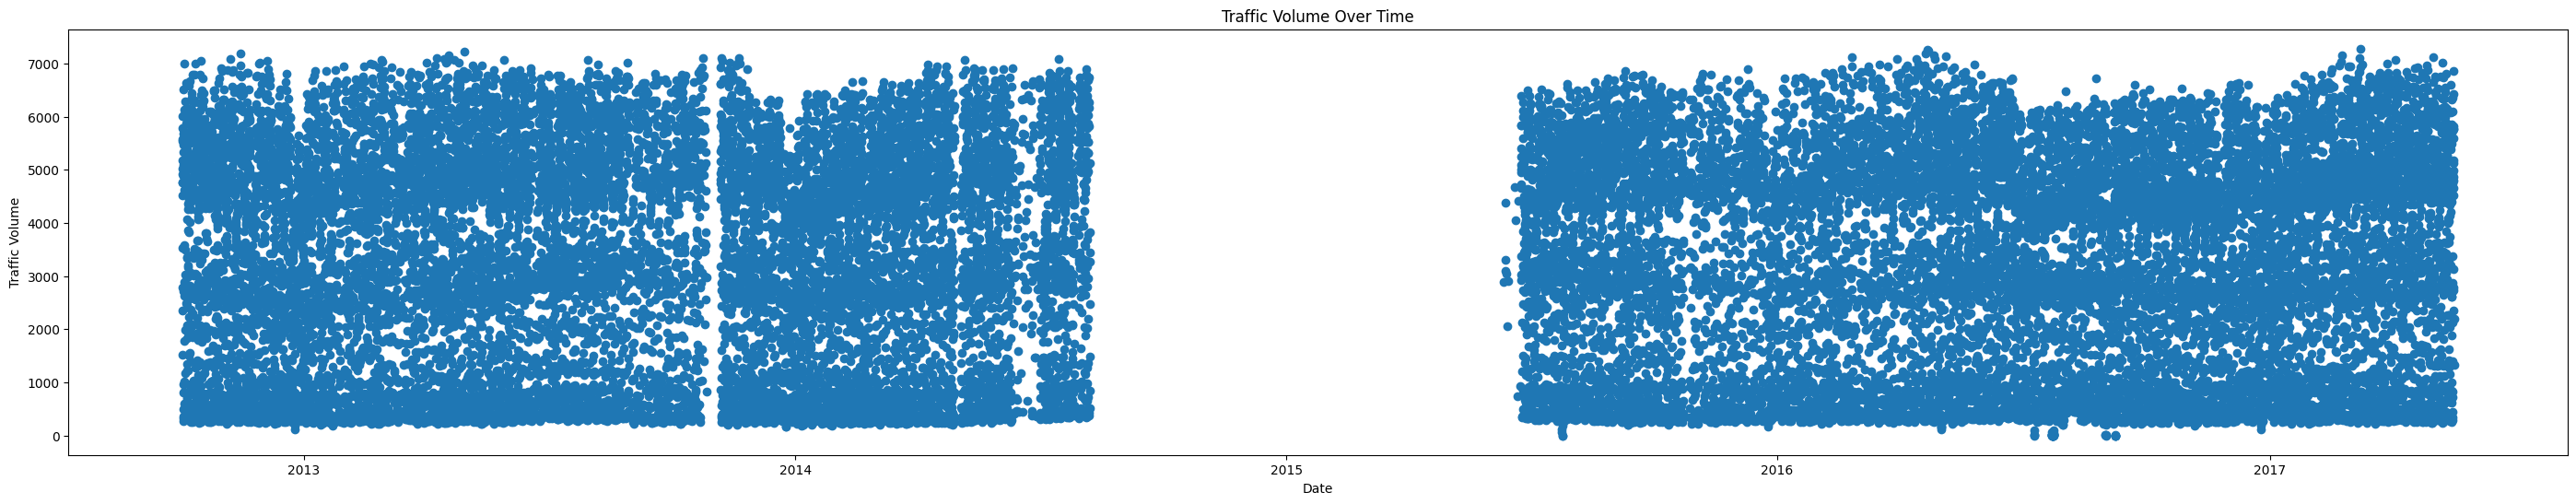

In [58]:
plt.figure(figsize=(35, 6))
plt.scatter(df_grouped.index,df_grouped['traffic_volume'])
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.show()

In [59]:
firsthalf_firstindex = df_grouped.index.min()
firsthalf_lastindex = df_grouped.loc[df_grouped.index.year == 2014].index.max()
secondhalf_firstindex = df_grouped.loc[df_grouped.index.year == 2015].index.min()
secondhalf_lastindex = df_grouped.index.max()

print(f'First Half: {firsthalf_firstindex} until {firsthalf_lastindex}')
print(f'Second Half: {secondhalf_firstindex} until {secondhalf_lastindex}')

First Half: 2012-10-02 09:00:00 until 2014-08-08 01:00:00
Second Half: 2015-06-11 20:00:00 until 2017-05-17 23:00:00


In [60]:
df_first = df_grouped[:firsthalf_lastindex]
df_second = df_grouped[secondhalf_firstindex:]

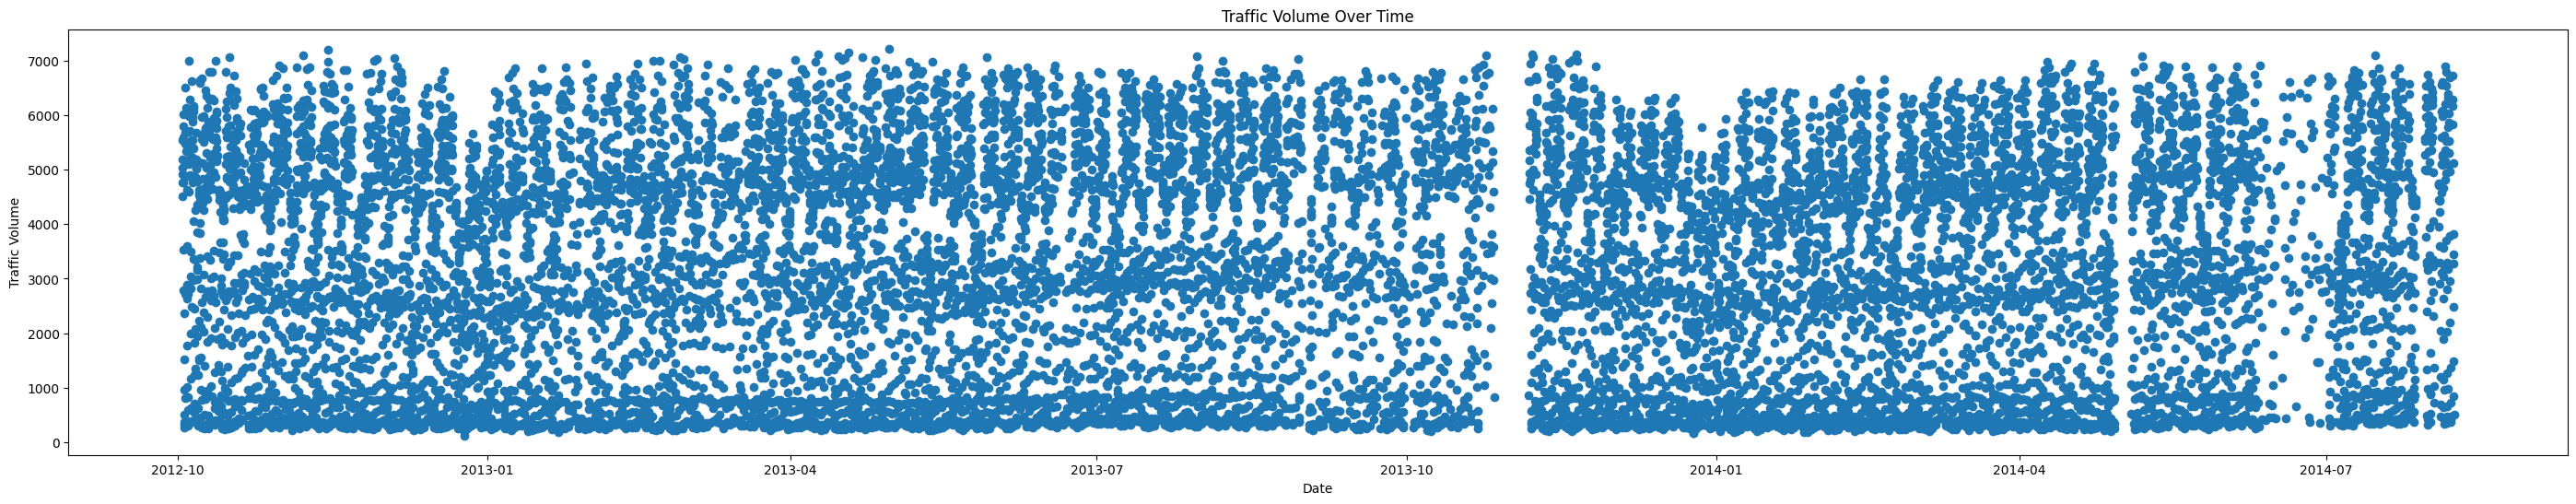

In [61]:
plt.figure(figsize=(35, 6))
plt.scatter(df_first.index,df_first['traffic_volume'])
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.show()

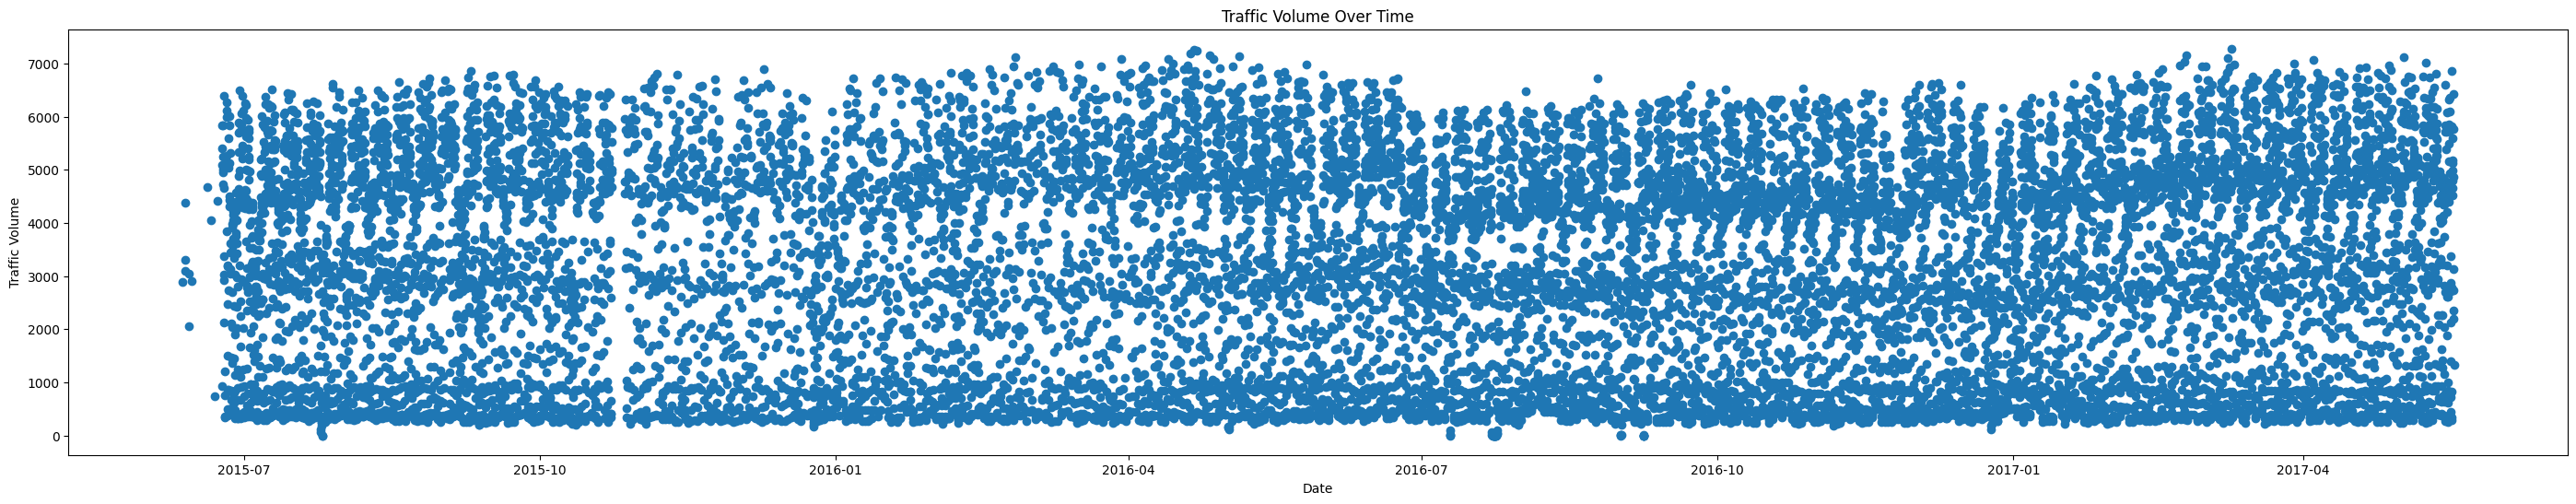

In [62]:
plt.figure(figsize=(35, 6))
plt.scatter(df_second.index,df_second['traffic_volume'])
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.show()

In [63]:
df_first.info()
df_second.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13898 entries, 2012-10-02 09:00:00 to 2014-08-08 01:00:00
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_holiday           18 non-null     object 
 1   air_pollution_index  13898 non-null  float64
 2   humidity             13898 non-null  float64
 3   wind_speed           13898 non-null  float64
 4   wind_direction       13898 non-null  float64
 5   visibility_in_miles  13898 non-null  float64
 6   dew_point            13898 non-null  float64
 7   temperature          13898 non-null  float64
 8   rain_p_h             13898 non-null  float64
 9   snow_p_h             13898 non-null  float64
 10  clouds_all           13898 non-null  float64
 11  weather_type         13898 non-null  object 
 12  weather_description  13898 non-null  object 
 13  traffic_volume       13898 non-null  float64
dtypes: float64(11), object(3)
memory usage: 1.6+ MB
<cl

# Fill missing records - Make new rows

In [64]:
complete_range_first = pd.date_range(firsthalf_firstindex, firsthalf_lastindex, freq='H')
df_complete_first = pd.DataFrame(index=complete_range_first)
complete_range_second = pd.date_range(secondhalf_firstindex, secondhalf_lastindex, freq='H')
df_complete_second = pd.DataFrame(index=complete_range_second)

In [65]:
# Merge the existing DataFrame with the complete DataFrame
df_merged_first = df_complete_first.merge(df_first, how='left', left_index=True, right_index=True)
df_merged_second = df_complete_second.merge(df_second, how='left', left_index=True, right_index=True)

In [66]:
df_merged_first.info()
df_merged_second.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16193 entries, 2012-10-02 09:00:00 to 2014-08-08 01:00:00
Freq: H
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_holiday           18 non-null     object 
 1   air_pollution_index  13898 non-null  float64
 2   humidity             13898 non-null  float64
 3   wind_speed           13898 non-null  float64
 4   wind_direction       13898 non-null  float64
 5   visibility_in_miles  13898 non-null  float64
 6   dew_point            13898 non-null  float64
 7   temperature          13898 non-null  float64
 8   rain_p_h             13898 non-null  float64
 9   snow_p_h             13898 non-null  float64
 10  clouds_all           13898 non-null  float64
 11  weather_type         13898 non-null  object 
 12  weather_description  13898 non-null  object 
 13  traffic_volume       13898 non-null  float64
dtypes: float64(11), object(3)
memory usage: 2.4

In [67]:
df_merged_first.isnull().sum()

is_holiday             16175
air_pollution_index     2295
humidity                2295
wind_speed              2295
wind_direction          2295
visibility_in_miles     2295
dew_point               2295
temperature             2295
rain_p_h                2295
snow_p_h                2295
clouds_all              2295
weather_type            2295
weather_description     2295
traffic_volume          2295
dtype: int64

In [68]:
df_merged_second.isnull().sum()

is_holiday             16928
air_pollution_index     2257
humidity                2257
wind_speed              2257
wind_direction          2257
visibility_in_miles     2257
dew_point               2257
temperature             2257
rain_p_h                2257
snow_p_h                2257
clouds_all              2257
weather_type            2257
weather_description     2257
traffic_volume          2257
dtype: int64

# Fill missing records - is_holiday

In [69]:
# Make dictionary to save holiday name and it's date

# Create an empty dictionary to store the results
holiday_dict = {}

# Iterate through the DataFrame
for index, row in df.iterrows():
    holiday = row['is_holiday']
    date_time = row['date_time']
    
    # Check if the holiday is not null and has not been encountered before
    if pd.notnull(holiday) and holiday not in holiday_dict:
        # Extract month and date from the date_time and store it in the dictionary
        holiday_dict[date_time.strftime('%d-%m')] = holiday

# Print the resulting dictionary
print(holiday_dict)

{'08-10': 'columbus day', '12-11': 'veterans day', '22-11': 'thanksgiving day', '25-12': 'christmas day', '01-01': 'new years day', '18-02': 'washingtons birthday', '27-05': 'memorial day', '04-07': 'independence day', '22-08': 'state fair', '02-09': 'labor day', '14-10': 'columbus day', '11-11': 'veterans day', '28-11': 'thanksgiving day', '20-01': 'martin luther king jr day', '17-02': 'washingtons birthday', '26-05': 'memorial day', '03-07': 'independence day', '27-08': 'state fair', '07-09': 'labor day', '12-10': 'columbus day', '26-11': 'thanksgiving day', '15-02': 'washingtons birthday', '30-05': 'memorial day', '25-08': 'state fair', '05-09': 'labor day', '10-10': 'columbus day', '24-11': 'thanksgiving day', '26-12': 'christmas day', '02-01': 'new years day', '16-01': 'martin luther king jr day', '20-02': 'washingtons birthday'}


In [70]:
holiday_dict

{'08-10': 'columbus day',
 '12-11': 'veterans day',
 '22-11': 'thanksgiving day',
 '25-12': 'christmas day',
 '01-01': 'new years day',
 '18-02': 'washingtons birthday',
 '27-05': 'memorial day',
 '04-07': 'independence day',
 '22-08': 'state fair',
 '02-09': 'labor day',
 '14-10': 'columbus day',
 '11-11': 'veterans day',
 '28-11': 'thanksgiving day',
 '20-01': 'martin luther king jr day',
 '17-02': 'washingtons birthday',
 '26-05': 'memorial day',
 '03-07': 'independence day',
 '27-08': 'state fair',
 '07-09': 'labor day',
 '12-10': 'columbus day',
 '26-11': 'thanksgiving day',
 '15-02': 'washingtons birthday',
 '30-05': 'memorial day',
 '25-08': 'state fair',
 '05-09': 'labor day',
 '10-10': 'columbus day',
 '24-11': 'thanksgiving day',
 '26-12': 'christmas day',
 '02-01': 'new years day',
 '16-01': 'martin luther king jr day',
 '20-02': 'washingtons birthday'}

In [71]:
df_holiday_first = df_merged_first
df_holiday_second = df_merged_second

In [72]:
df_holiday_first['date'] = df_holiday_first.index
df_holiday_second['date'] = df_holiday_second.index

In [73]:
df_holiday_first['date'] = df_holiday_first['date'].dt.strftime('%d-%m')
df_holiday_second['date'] = df_holiday_second['date'].dt.strftime('%d-%m')

In [74]:
df_holiday_first['is_holiday'] = df_holiday_first['date'].map(holiday_dict)
df_holiday_second['is_holiday'] = df_holiday_second['date'].map(holiday_dict)

In [75]:
df_holiday_first['is_holiday'] = df_holiday_first['is_holiday'].fillna('Not a Holiday')
df_holiday_second['is_holiday'] = df_holiday_second['is_holiday'].fillna('Not a Holiday')

In [76]:
df_holiday_first.info()
df_holiday_second.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16193 entries, 2012-10-02 09:00:00 to 2014-08-08 01:00:00
Freq: H
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_holiday           16193 non-null  object 
 1   air_pollution_index  13898 non-null  float64
 2   humidity             13898 non-null  float64
 3   wind_speed           13898 non-null  float64
 4   wind_direction       13898 non-null  float64
 5   visibility_in_miles  13898 non-null  float64
 6   dew_point            13898 non-null  float64
 7   temperature          13898 non-null  float64
 8   rain_p_h             13898 non-null  float64
 9   snow_p_h             13898 non-null  float64
 10  clouds_all           13898 non-null  float64
 11  weather_type         13898 non-null  object 
 12  weather_description  13898 non-null  object 
 13  traffic_volume       13898 non-null  float64
 14  date                 16193 non-null  object

In [77]:
df_holiday_first.drop(columns=['date'], inplace=True)
df_holiday_second.drop(columns=['date'], inplace=True)

In [78]:
df_holiday_first.info()
df_holiday_second.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16193 entries, 2012-10-02 09:00:00 to 2014-08-08 01:00:00
Freq: H
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_holiday           16193 non-null  object 
 1   air_pollution_index  13898 non-null  float64
 2   humidity             13898 non-null  float64
 3   wind_speed           13898 non-null  float64
 4   wind_direction       13898 non-null  float64
 5   visibility_in_miles  13898 non-null  float64
 6   dew_point            13898 non-null  float64
 7   temperature          13898 non-null  float64
 8   rain_p_h             13898 non-null  float64
 9   snow_p_h             13898 non-null  float64
 10  clouds_all           13898 non-null  float64
 11  weather_type         13898 non-null  object 
 12  weather_description  13898 non-null  object 
 13  traffic_volume       13898 non-null  float64
dtypes: float64(11), object(3)
memory usage: 2.4

# Fill Missing Records - numerical

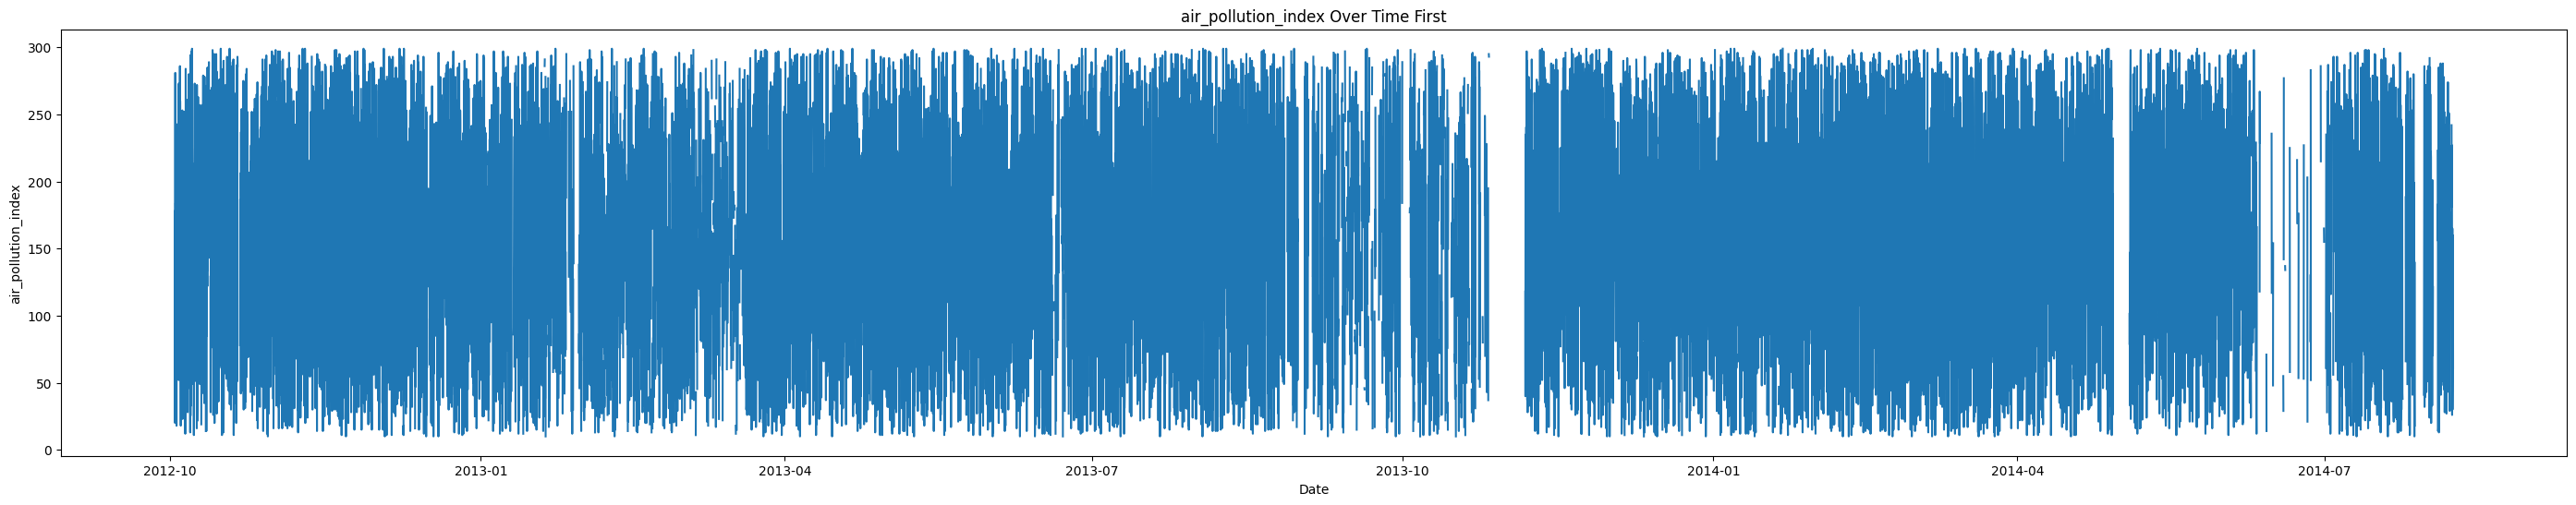

Text(0, 0.5, 'air_pollution_index')

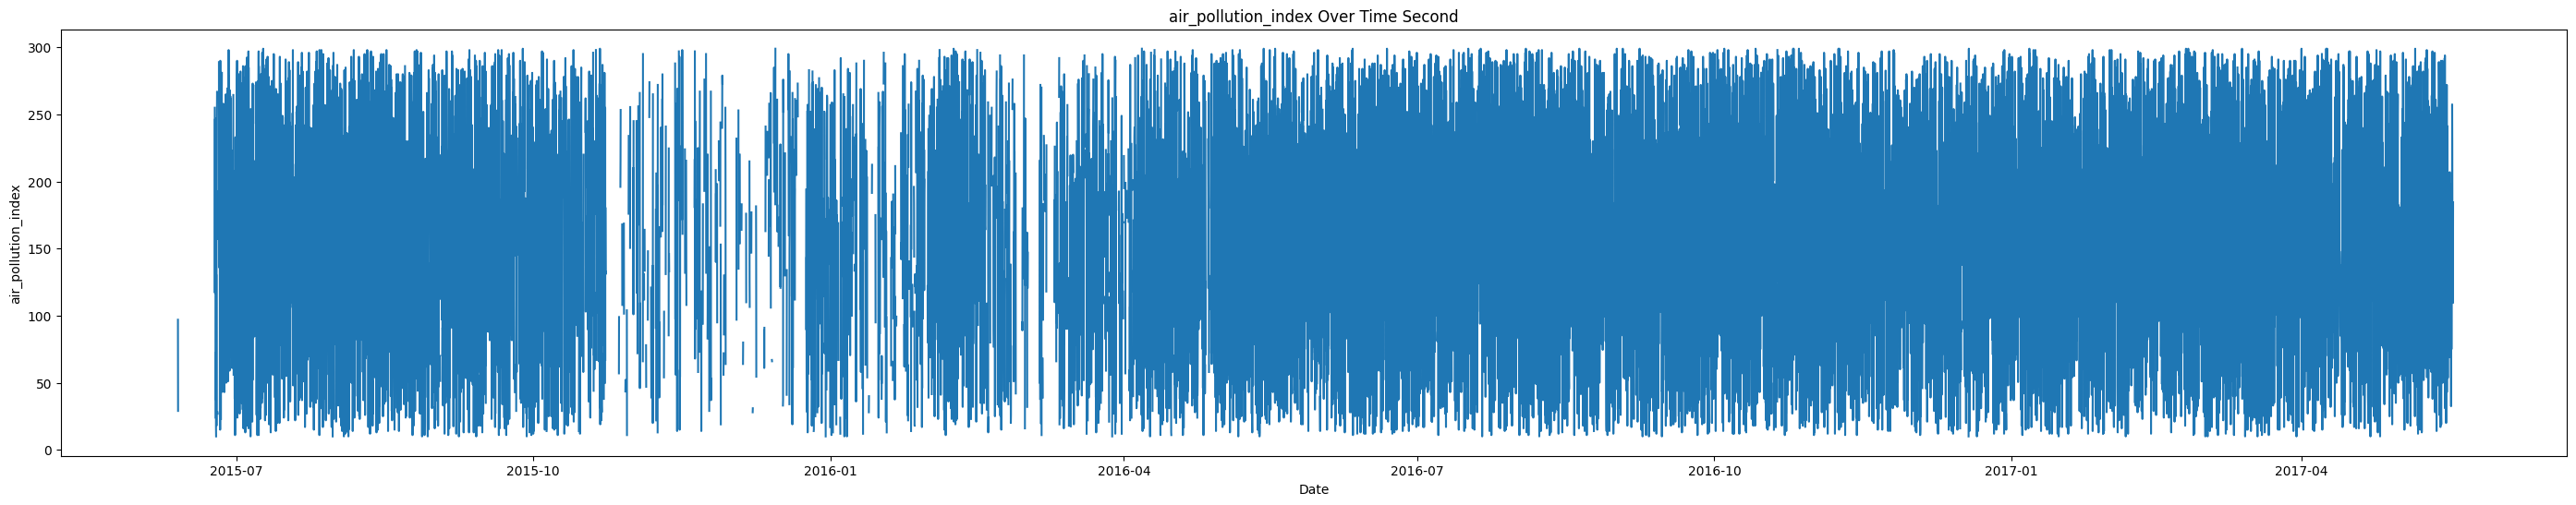

In [79]:
plt.figure(figsize=(35, 6))
plt.plot(df_holiday_first.index, df_holiday_first['air_pollution_index'])
plt.title('air_pollution_index Over Time First')
plt.xlabel('Date')
plt.ylabel('air_pollution_index')
plt.show()
plt.figure(figsize=(35, 6))
plt.plot(df_holiday_second.index, df_holiday_second['air_pollution_index'])
plt.title('air_pollution_index Over Time Second')
plt.xlabel('Date')
plt.ylabel('air_pollution_index')

In [80]:
df_fillnum_first = df_holiday_first.copy()
df_fillnum_second = df_holiday_second.copy()

In [81]:
numerical_columns = df_fillnum_first.select_dtypes(include=['float64']).columns
numerical_columns

Index(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
       'snow_p_h', 'clouds_all', 'traffic_volume'],
      dtype='object')

In [82]:
for column in numerical_columns:
    df_fillnum_first[column].interpolate(method='time', inplace=True)
    df_fillnum_second[column].interpolate(method='time', inplace=True)

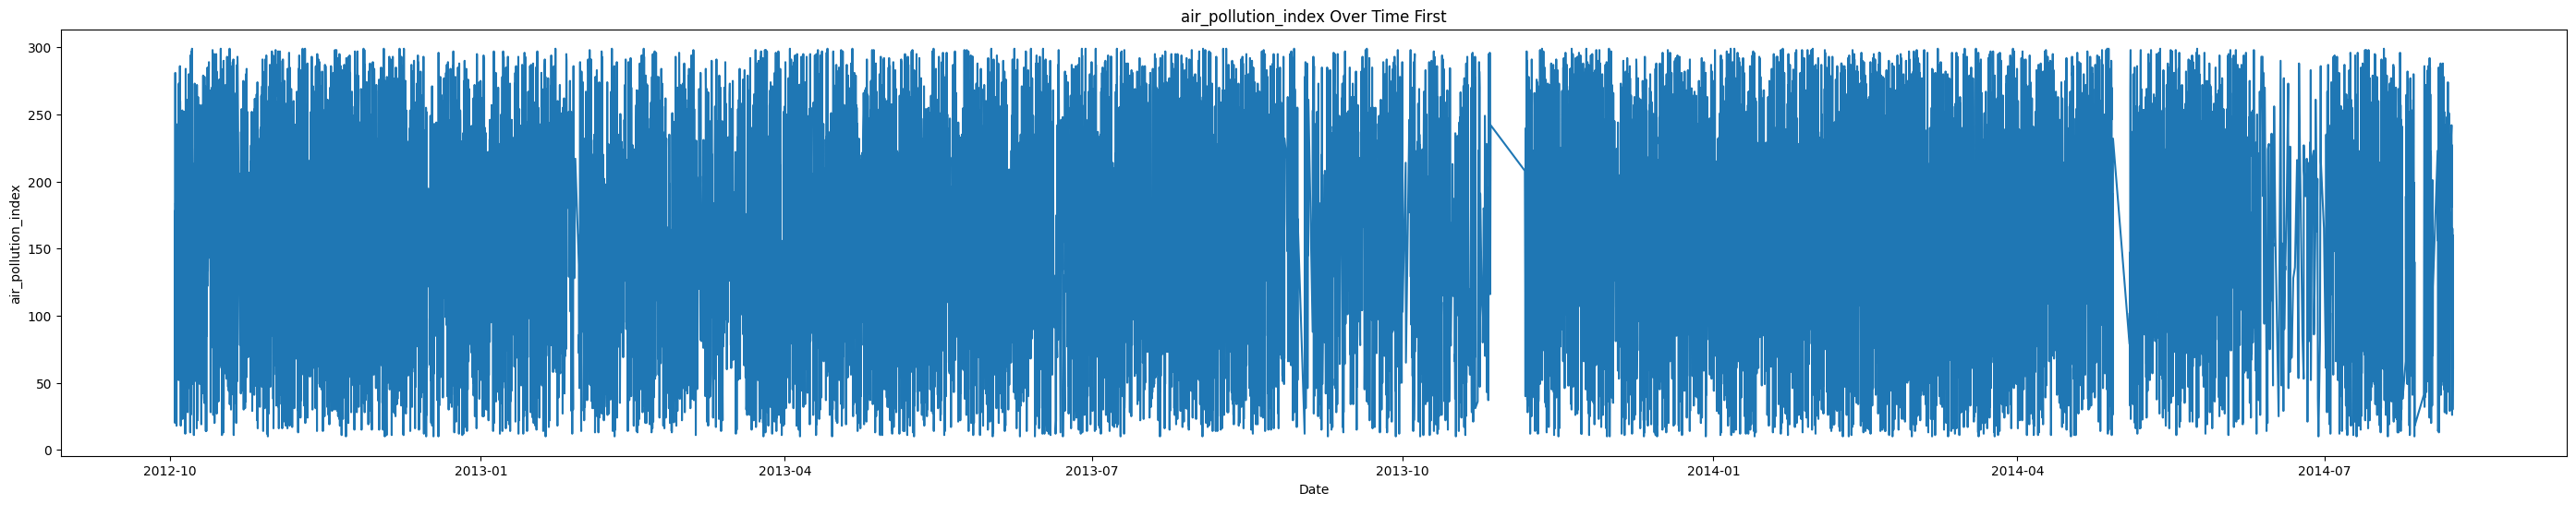

Text(0, 0.5, 'air_pollution_index')

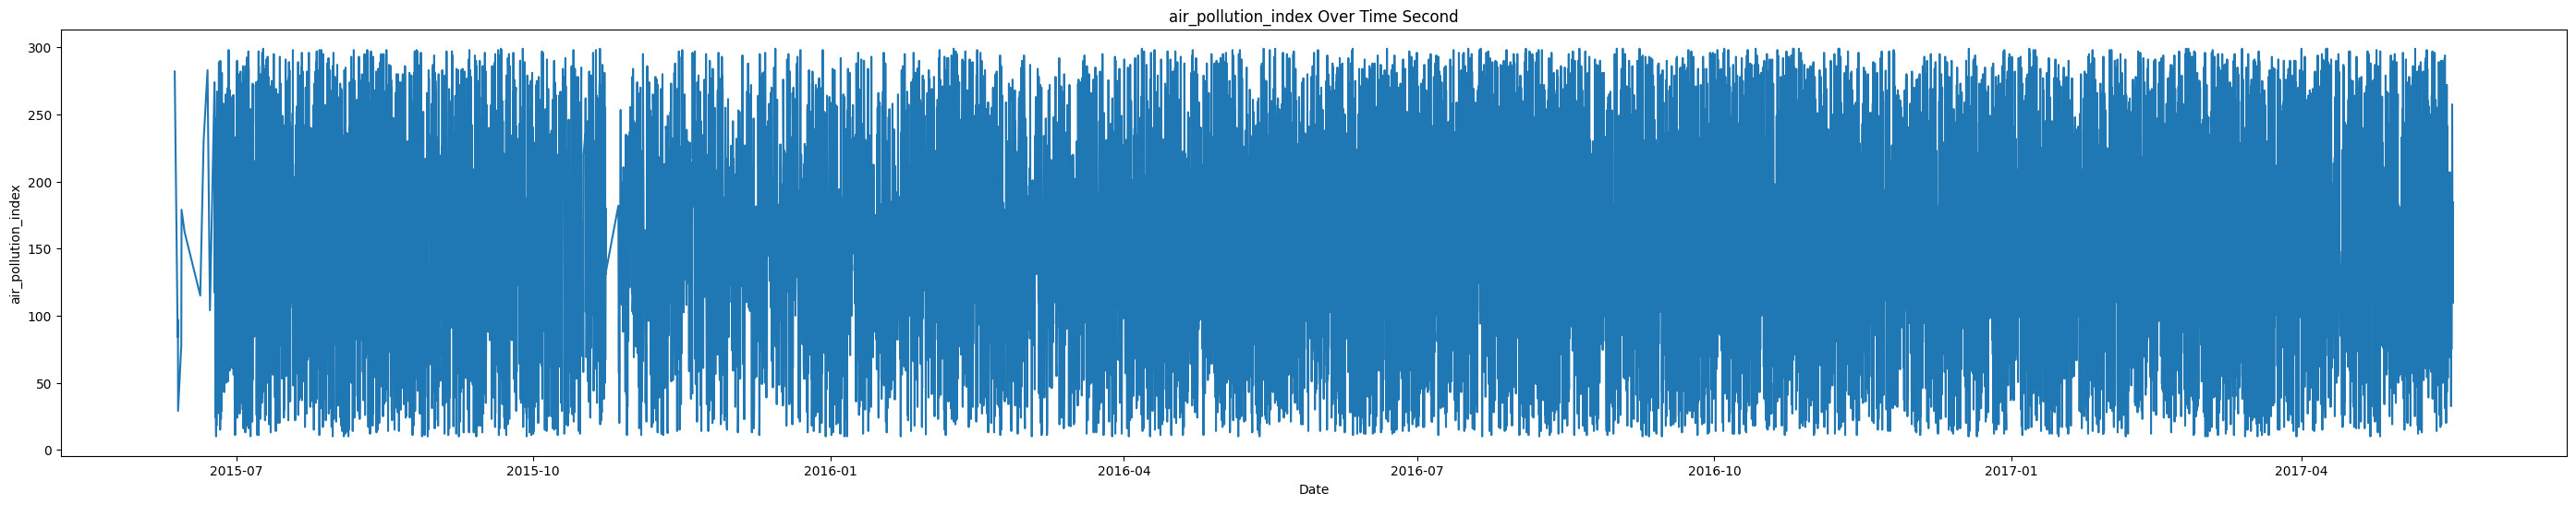

In [83]:
plt.figure(figsize=(35, 6))
plt.plot(df_fillnum_first.index, df_fillnum_first['air_pollution_index'])
plt.title('air_pollution_index Over Time First')
plt.xlabel('Date')
plt.ylabel('air_pollution_index')
plt.show()
plt.figure(figsize=(35, 6))
plt.plot(df_fillnum_second.index, df_fillnum_second['air_pollution_index'])
plt.title('air_pollution_index Over Time Second')
plt.xlabel('Date')
plt.ylabel('air_pollution_index')

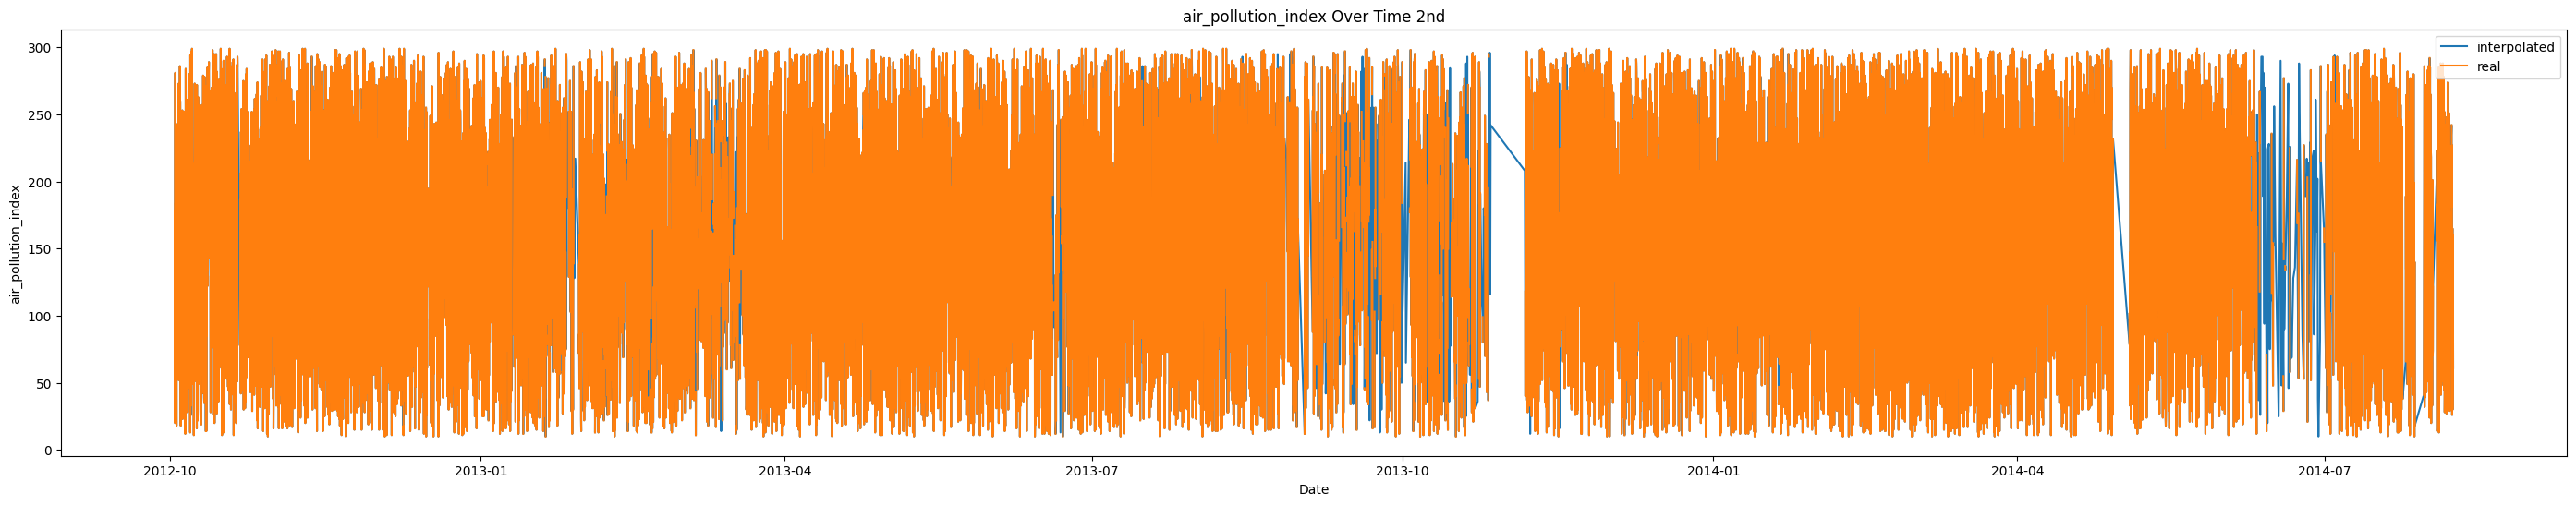

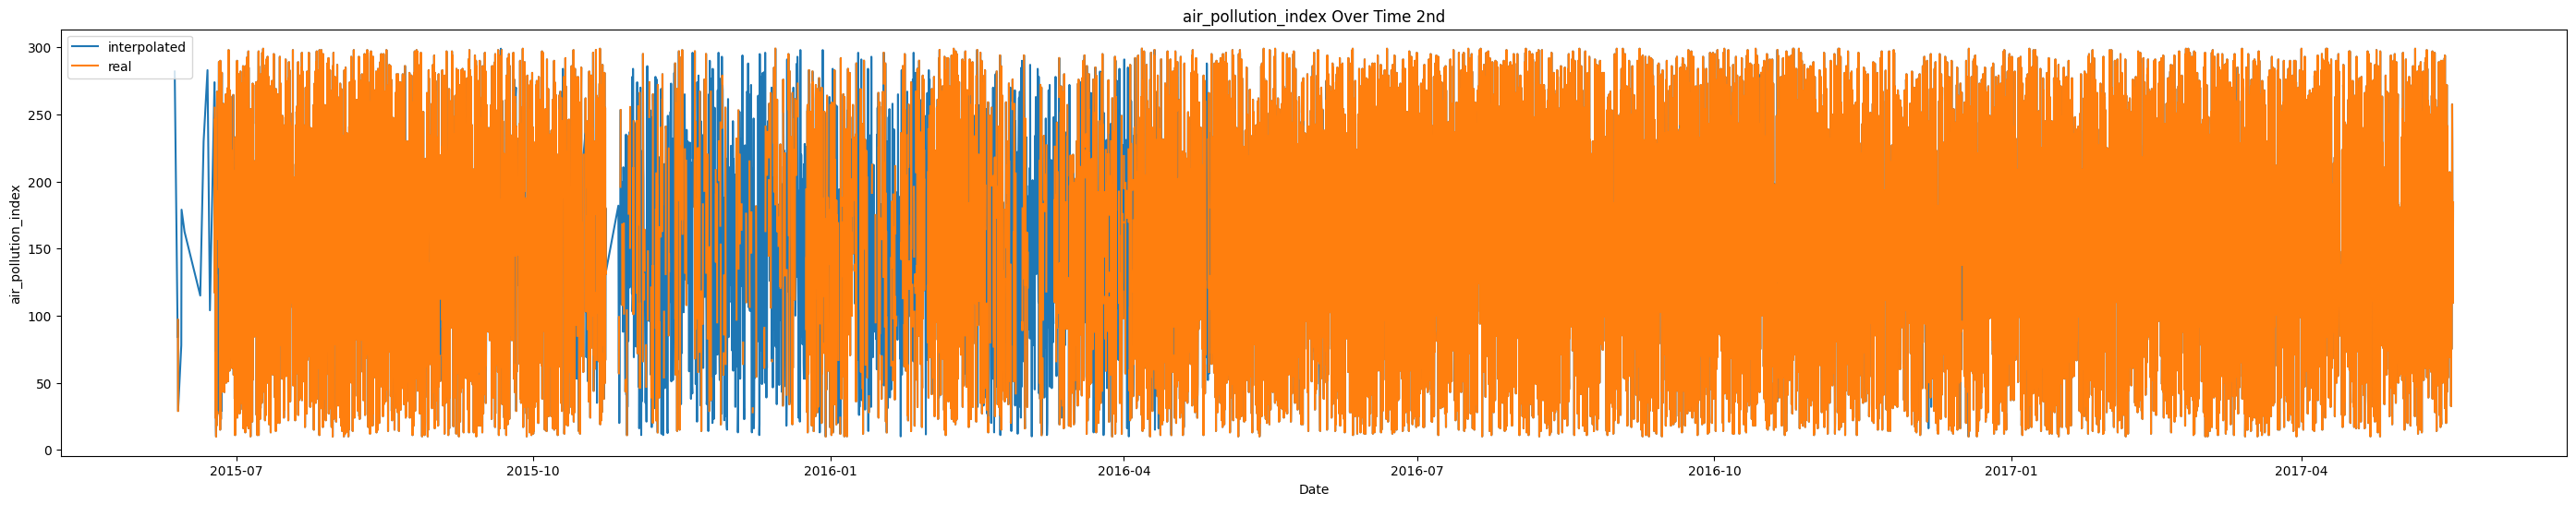

In [84]:
plt.figure(figsize=(35, 6))
plt.plot(df_fillnum_first['air_pollution_index'], label='interpolated')
plt.plot(df_holiday_first['air_pollution_index'], label='real')
plt.legend()
plt.title('air_pollution_index Over Time 2nd')
plt.xlabel('Date')
plt.ylabel('air_pollution_index')
plt.show()

plt.figure(figsize=(35, 6))
plt.plot(df_fillnum_second['air_pollution_index'], label='interpolated')
plt.plot(df_holiday_second['air_pollution_index'], label='real')
plt.legend()
plt.title('air_pollution_index Over Time 2nd')
plt.xlabel('Date')
plt.ylabel('air_pollution_index')
plt.show()

# Fill Missing Records - Categorical

In [85]:
import pandas as pd
from datetime import timedelta

def fill_categorical_missing(df, column_name):

    # Iterate through each row with missing values in the specified column
    for index, row in df[df[column_name].isnull()].iterrows():
        date = index.date()
        yesterday = date - timedelta(days=1)
        tomorrow = date + timedelta(days=1)

        # Check if there are other records with the same day
        same_day_records = df[df.index.date == date]
        yesterday_records = df[df.index.date == yesterday]
        tomorrow_records = df[df.index.date == tomorrow]

        same_day_records = same_day_records.dropna(subset=[column_name])
        yesterday_records = yesterday_records.dropna(subset=[column_name])
        tomorrow_records = tomorrow_records.dropna(subset=[column_name])

        if not same_day_records.empty:
            # Fill with mode if other records exist for the same day
            mode_values = same_day_records[column_name].mode()
            if not mode_values.empty:
                df.at[index, column_name] = mode_values.iloc[0]
        else:
            # Fill based on conditions for the next day
            if not tomorrow_records.empty:
                # Fill first half with mode of day before, second half with mode of next day
                noon_time = pd.to_datetime('12:00:00').time()
                
                # Check if the time is before 12 pm
                if index.time() < noon_time:
                    df.at[index, column_name] = yesterday_records[column_name].mode().iloc[0]
                else:
                    df.at[index, column_name] = tomorrow_records[column_name].mode().iloc[0]
            else:
                # Fill all with mode of day before if no record on the next day
                mode_values = yesterday_records[column_name].mode()
                if not mode_values.empty:
                    df.at[index, column_name] = mode_values.iloc[0]
    return df

In [86]:
df_fillcat_first = df_fillnum_first.copy()
df_fillcat_second = df_fillnum_second.copy()

In [87]:
categorical_columns = df_fillnum_first.select_dtypes(include=['object']).columns
categorical_columns

Index(['is_holiday', 'weather_type', 'weather_description'], dtype='object')

In [88]:
for column in categorical_columns:
    df_fillcat_first = fill_categorical_missing(df_fillcat_first, column)
    df_fillcat_second = fill_categorical_missing(df_fillcat_second, column)

In [89]:
df_fillcat_first.info()
df_fillcat_second.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16193 entries, 2012-10-02 09:00:00 to 2014-08-08 01:00:00
Freq: H
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_holiday           16193 non-null  object 
 1   air_pollution_index  16193 non-null  float64
 2   humidity             16193 non-null  float64
 3   wind_speed           16193 non-null  float64
 4   wind_direction       16193 non-null  float64
 5   visibility_in_miles  16193 non-null  float64
 6   dew_point            16193 non-null  float64
 7   temperature          16193 non-null  float64
 8   rain_p_h             16193 non-null  float64
 9   snow_p_h             16193 non-null  float64
 10  clouds_all           16193 non-null  float64
 11  weather_type         16193 non-null  object 
 12  weather_description  16193 non-null  object 
 13  traffic_volume       16193 non-null  float64
dtypes: float64(11), object(3)
memory usage: 2.4

In [90]:
df_fillcat_second['weather_description'].value_counts()

weather_description
sky is clear                    6310
overcast clouds                 1998
scattered clouds                1243
broken clouds                   1157
mist                            1015
light rain                      1012
light snow                       964
few clouds                       706
haze                             571
light intensity drizzle          538
drizzle                          440
fog                              415
moderate rain                    258
heavy intensity rain             170
proximity thunderstorm            51
proximity shower rain             33
heavy intensity drizzle           24
thunderstorm                      14
snow                               9
thunderstorm with light rain       4
heavy snow                         4
very heavy rain                    4
light shower snow                  4
light intensity shower rain        3
freezing rain                      1
Name: count, dtype: int64

# Return the date_time column so it fit the preprocessing later

In [91]:
df_fillcat_first['date_time'] = df_fillcat_first.index
df_fillcat_second['date_time'] = df_fillcat_second.index

In [92]:
df_fillcat_first.info()
df_fillcat_second.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16193 entries, 2012-10-02 09:00:00 to 2014-08-08 01:00:00
Freq: H
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   is_holiday           16193 non-null  object        
 1   air_pollution_index  16193 non-null  float64       
 2   humidity             16193 non-null  float64       
 3   wind_speed           16193 non-null  float64       
 4   wind_direction       16193 non-null  float64       
 5   visibility_in_miles  16193 non-null  float64       
 6   dew_point            16193 non-null  float64       
 7   temperature          16193 non-null  float64       
 8   rain_p_h             16193 non-null  float64       
 9   snow_p_h             16193 non-null  float64       
 10  clouds_all           16193 non-null  float64       
 11  weather_type         16193 non-null  object        
 12  weather_description  16193 non-null  object  

In [98]:
df_fillcat_first['is_holiday'].value_counts()

is_holiday
Not a Holiday                14849
columbus day                   192
thanksgiving day               192
washingtons birthday           192
memorial day                   144
veterans day                    96
christmas day                   96
new years day                   96
martin luther king jr day       96
independence day                96
state fair                      72
labor day                       72
Name: count, dtype: int64

In [99]:
# df_fillcat_first.to_csv('outputs/new_splitted/firsthalf.csv', index=False)
# df_fillcat_second.to_csv('outputs/new_splitted/secondhalf.csv', index=False)